In [357]:
cache_processed_data = True 

# Run List

In [61]:
root = "../data/081221_final_fishhook_tests/"
run_list = '.run_list.temp'
!ls {root} -1 | tee {run_list}

pretest_1
pretest_2
stationary_1
stationary_2
stationary_3
stationary_4
stationary_5
stationary_6
stationary_7
stationary_8
triangle_1
triangle_2
triangle_3


In [2]:
runs = [a.strip() for a in open(run_list) if a != '']

In [3]:
fs = 1e6
dt = 1.0 / fs

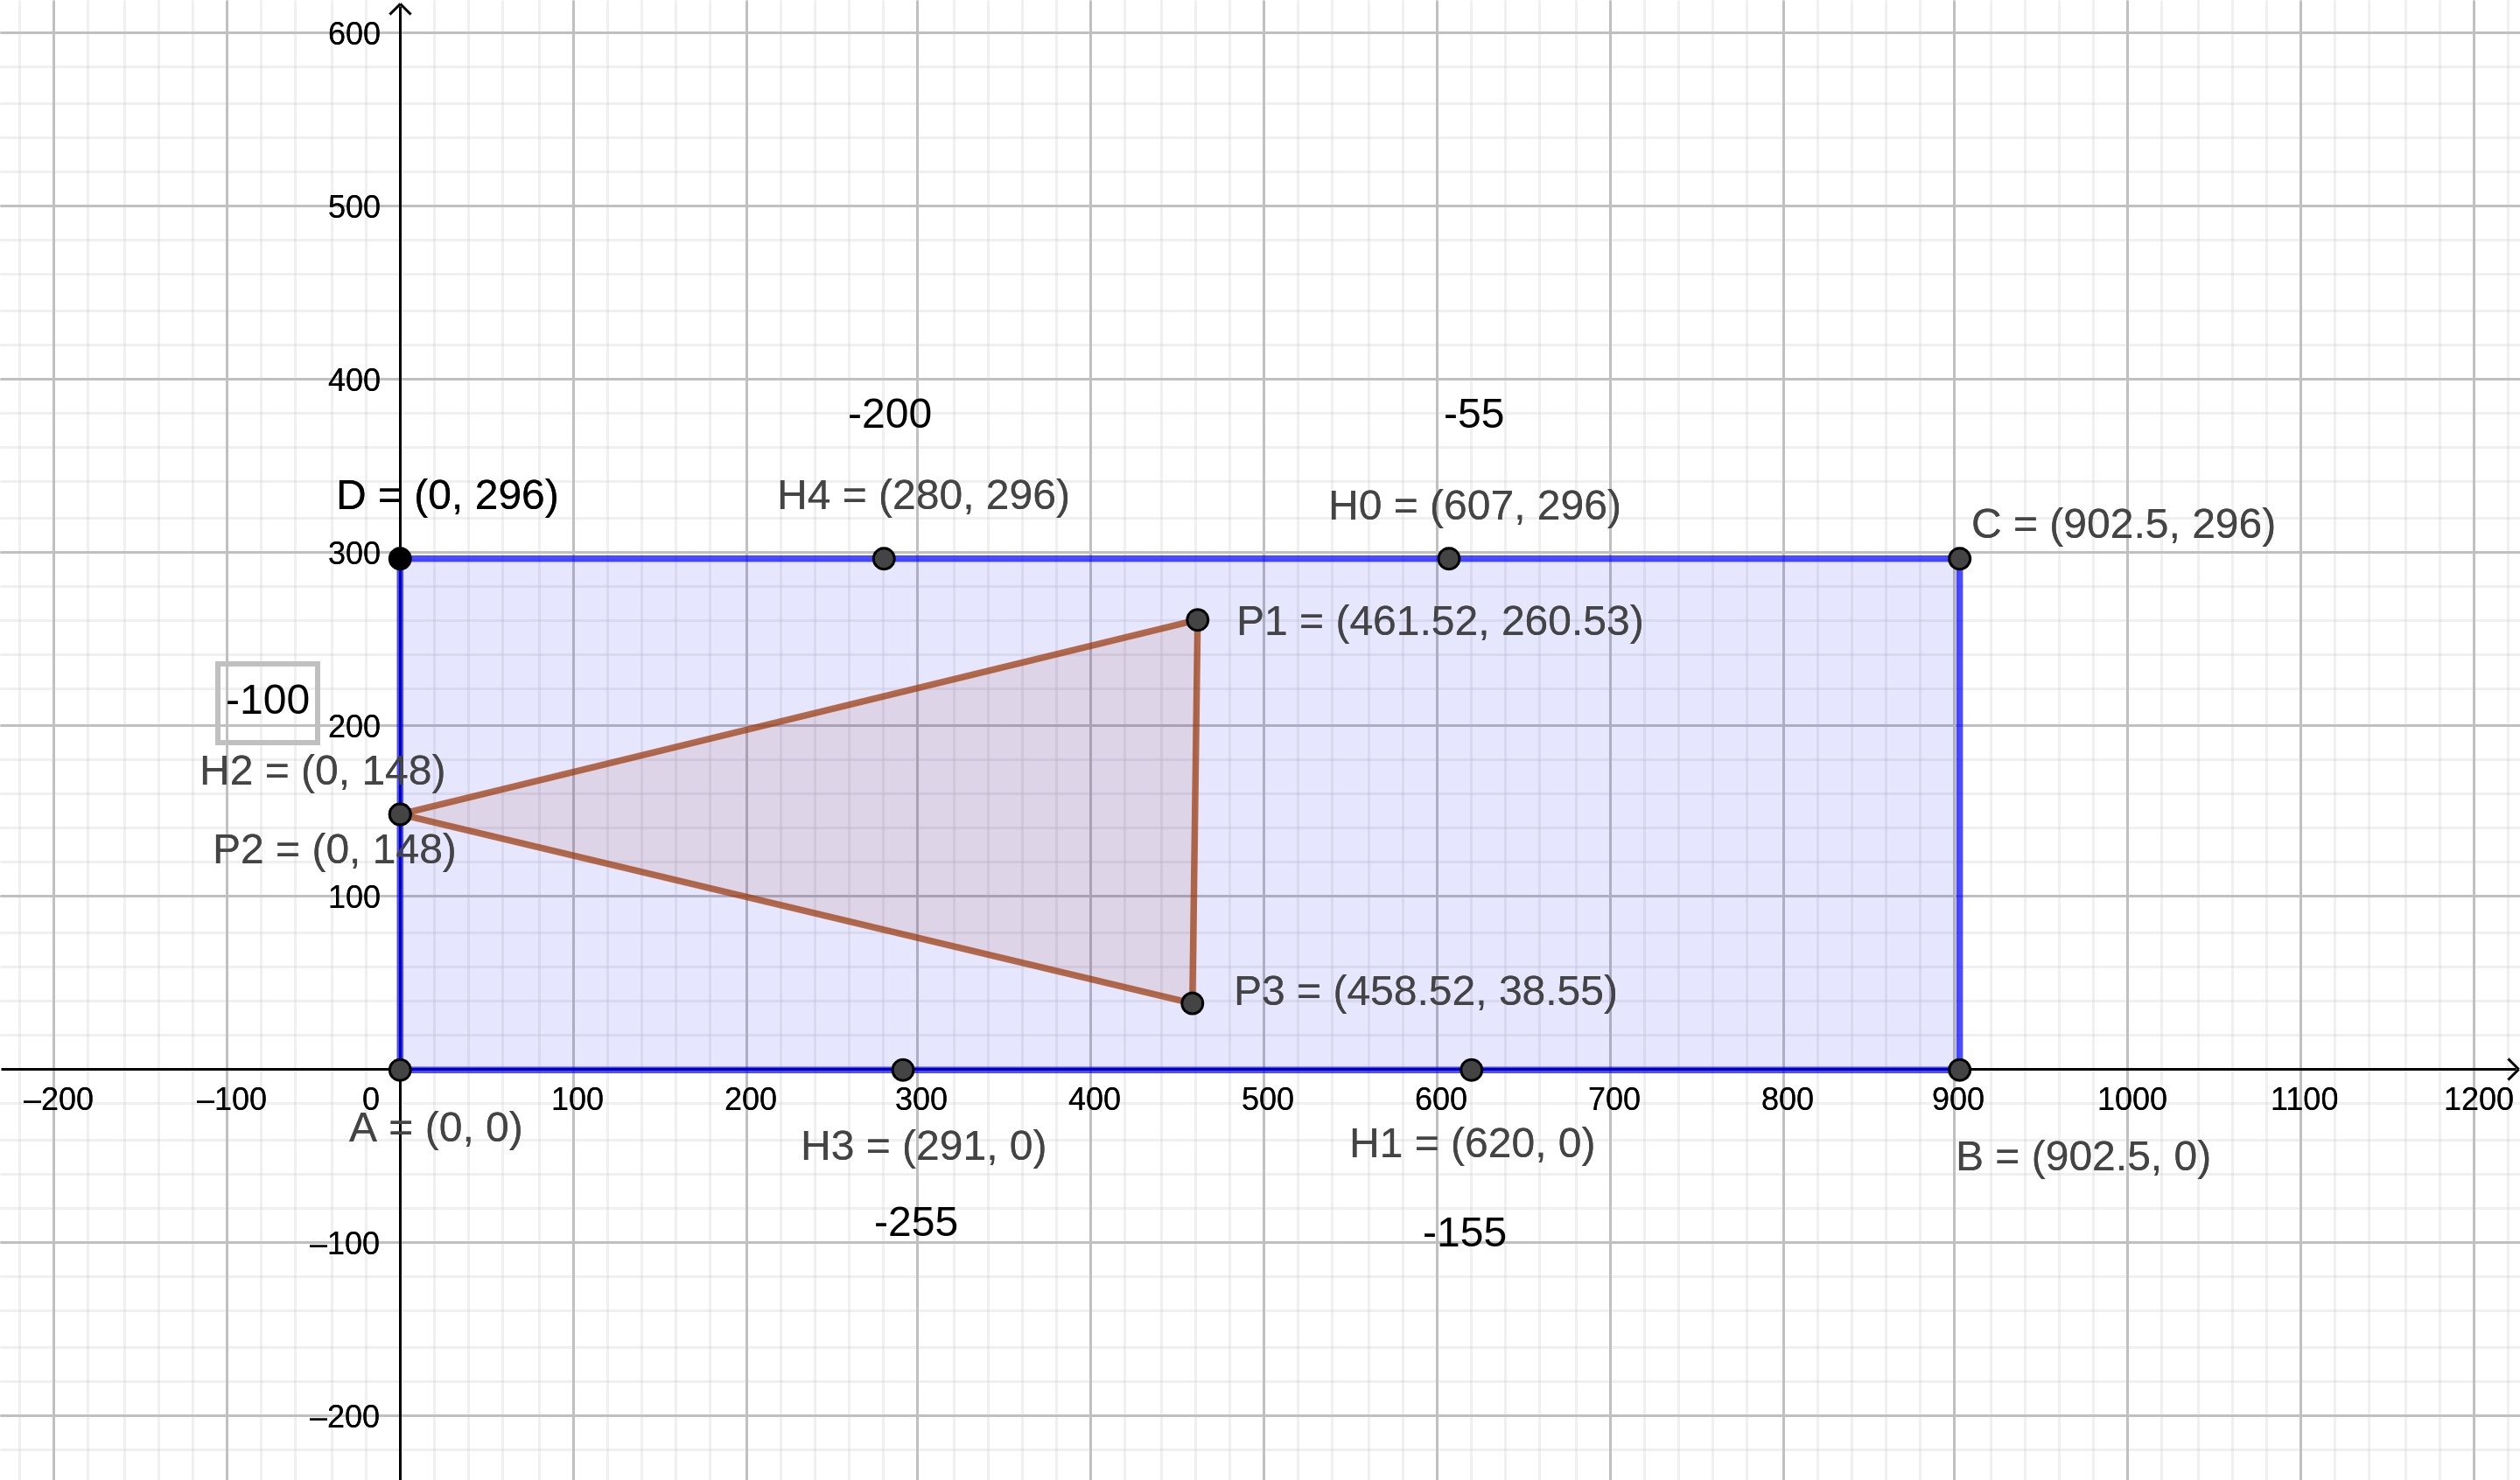


In [4]:
import numpy as np

In [6]:
L = 9.025
W = 2.96
D = -3.5

h_locs = np.array((
    (607, 296,  -55),
    (620,   0, -155),
    (  0, 148, -100),
    (291,   0, -255),
    (280, 296, -200),
)).astype(np.float64)
h_locs /= 100

ground_truth = np.array((
    (461.52, 260.53),
    (  0.00, 148.00),
    (458.52,  38.55),
)).astype(np.float64)
ground_truth /= 100
ground_truth = np.vstack((ground_truth, ground_truth[0:1, ...]))

# Helpers

## Pico Loader

In [358]:
import numpy as np

from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=1e6, low=30e3, high=50e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)

class MA:
    def __init__(self, fs=1e6, dt=1e-3, apply_abs=True):
        self.n = int(fs * dt)
        self.kernel = np.ones((self.n,), dtype=np.int32) / self.n
        self.apply_abs = apply_abs

    def __call__(self, data):
        if self.apply_abs:
            if len(data.shape) == 1:
                return np.convolve(np.abs(data), self.kernel, mode='same')

            out = np.empty_like(data)
            for i in range(data.shape[1]):
                out[:, i] = np.convolve(np.abs(data[:, i]), self.kernel, mode='same')
            return out
        else:
            if len(data.shape) == 1:
                return np.convolve(data, self.kernel, mode='same')

            out = np.empty_like(data)
            for i in range(data.shape[1]):
                out[:, i] = np.convolve(data[:, i], self.kernel, mode='same')
            return out
            

class Hilbert:
    def __init__(self, fs=1e6):
        pass

    def __call__(self, data):
        return np.abs(hilbert(data))

    
import struct
class PicoDataLoader:
    bufsize = 100000
    time_len = struct.calcsize('<d')
    time_unpack = struct.Struct('<d').unpack_from
    
    def __init__(self, filename, # filename: Union[str, path_like, File object]
                 bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
                 ma_args={'fs': fs, 'dt': 6e-5},
                 hil_args=None,  # {'fs': fs,},
                 preserve_chA=False,
                 num_channels=6
                ):  
        self.filename = filename
        self.file = None
        self.preserve_chA = preserve_chA
        self.num_channels = num_channels

        self.transformers = []
        if bp_args is not None:
            self.transformers.append(BP(**bp_args))
        if ma_args is not None:
            self.transformers.append(MA(**ma_args))
        if hil_args is not None:
            self.transformers.append(Hilbert(**hil_args))
    
    def open(self):
        if self.file is not None:
            self.close()
        
        # For compatibility with tarfiles
        # See: https://github.com/numpy/numpy/issues/7989#issuecomment-340921579
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
    
    def get(self):
        if self.file is None:
            raise Exception("Use ```open``` and ```close```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))[0]
            arr = np.load(self.file)[:, :self.num_channels]
            dtype = arr.dtype
            
            if self.preserve_chA:
                chA = arr[:, 0].copy()
            
            for tran in self.transformers:
                arr = tran(arr)
            
            arr = arr.astype(dtype)
            if self.preserve_chA:
                arr[:, 0] = chA
            
            return t, arr
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def close(self):
        if self.file is not None:
            self.file.close()

    def __enter__(self):
        self.open()
        return self
    
    def __exit__(self, ex_type, value, traceback):
        self.close()

In [359]:
import numpy as np
import subprocess
from tqdm.notebook import trange
import functools

def conditional(dec, condition):
    def decorator(func):
        if condition:    
            return dec(func)
        return func
    return decorator

@conditional(functools.cache, cache_processed_data)
def load_pico_file(filename, num_channels=6):
    with PicoDataLoader(filename, bp_args=None, ma_args=None, hil_args=None) as reader:
        t0 = reader.get()[0]
    
    # WARNING: THIS IS A HACK! Note the magic numbers
    num_chunks = int(int(subprocess.run(f'du {reader.filename} | cut -f 1', shell=True, capture_output=True).stdout.decode('UTF-8')) // 1172)
    chunk_size = PicoDataLoader.bufsize
    y = np.empty((chunk_size * num_chunks, num_channels))
    index = 0
    arrs = []
    t_curr = t0
    with PicoDataLoader(filename, preserve_chA=True,
                 bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
                 ma_args=None,  #{'fs': fs, 'dt': 6e-5},
                 hil_args={'fs': fs,},
                 num_channels=num_channels,
                       ) as reader:
        try:
            for i in trange(num_chunks):
                t, y[index:index + chunk_size, ...] = reader.get()
                index += chunk_size
                t_curr += dt * chunk_size
        except StopIteration:
            print(f"Got {len(arrs)} chunks of {num_chunks} expected")
    
    t = np.arange(y.shape[0]) * dt

    t.flags.writeable = False
    y.flags.writeable = False

    return t, y

In [9]:
# import numpy as np
# import subprocess
# from tqdm.notebook import trange

# def load_run(filename, num_channels=6):
#     with PicoDataLoader(filename, bp_args=None, ma_args=None, hil_args=None) as reader:
#         t0 = reader.get()[0]

#     num_chunks = int(int(subprocess.run(f'du {reader.filename} | cut -f 1', shell=True, capture_output=True).stdout.decode('UTF-8')) // 1172)

#     arrs = []
#     t_curr = t0
#     with PicoDataLoader(filename, preserve_chA=True,
#                  bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
#                  ma_args=None,  #{'fs': fs, 'dt': 6e-5},
#                  hil_args={'fs': fs,},
#                  num_channels=num_channels,
#                        ) as reader:
#         try:
#             for i in trange(num_chunks):
#                 t, arr = reader.get()
#                 arrs.append(arr)
#                 # print(t - t0, t_curr - t0, t - t_curr)
#                 t_curr += dt * arr.shape[0]
#         except StopIteration:
#             print(f"Got {len(arrs)} chunks of {num_chunks} expected")
    
#     import time
#     t_start = time.time()
#     y = np.vstack(arrs)
#     t = np.arange(y.shape[0]) * dt
#     del arrs
#     print(time.time() - t_start)
#     # t.flags.writeable = False
#     # y.flags.writeable = False

#     return t, y

## Ping Indices

In [10]:
def get_ping_indices(ping_ch, fs=fs, pinger_zc_thresh=-1000, min_down_length=0.350):
    ping_ch = ping_ch.copy()
    ping_ch[0] = 0
    ping_ch[-1] = 0


    on = ping_ch < pinger_zc_thresh
    diff = np.diff(on.astype('int'))
    down = np.where(diff > 0)[0]
    up = np.where(diff < 0)[0]

    correct_mask = (up - down) > fs * min_down_length
    # 0.350 ~= 0.8 * (t_between_ping / 2)

    down = down[correct_mask]
    # down += 1  # For the diff
    
    del ping_ch  # Do we really need to?
    return down

## Zero Crossing

In [162]:
def get_simple_zc(ch, zero_crossing_thresh=250):
    # For boolean arrays it short circuits and returns the index of the first `True`. If no `True`, it returns `0` 
    return np.argmax(ch > zero_crossing_thresh, axis=0) 

## Ranges

In [112]:
def get_ranges(hydro, ping_index, fs=fs, max_dist=10, ping_size=5e-3, v_sound=1480):
    ping_len = max_dist / v_sound + ping_size
    win = slice(ping_index, ping_index + int(fs * ping_len))
    ranges = np.zeros((hydro.shape[1],))
    for i, row in enumerate(hydro[win, :].T):
        zero_in = get_simple_zc(row)  # Est_ZC_stage_1(row)
        if zero_in <= 0: 
            zero_in = np.nan
        ranges[i] = zero_in * v_sound / fs
        if ranges[i] < 0:
            print(zero_in,v_sound, fs)
            raise Exception()
        if ranges[i] > max_dist:
            ranges[i] = np.nan
    return ranges

## Draw Pool

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp_patches  # For circles and rectangles

In [114]:
def draw_pool(ax, set_lim=True):
    ax.set_aspect('equal', 'box')
    if set_lim:
        ax.set_xlim(0, L)
        ax.set_ylim(0, W)
    ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1, color='blue'))
    ax.scatter(h_locs[:, 0], h_locs[:, 1], color='red', s=200)

    ax.plot(*ground_truth.T, color='green')

# Load Run

In [343]:
run = runs[1]  #runs[8]
run

'pretest_2'

In [344]:
pico_file = f"{root}/{run}/pico.npts"
!du -h {pico_file}

130M	../data/081221_final_fishhook_tests//pretest_2/pico.npts


In [345]:
t, y = load_pico_file(pico_file)

  0%|          | 0/113 [00:00<?, ?it/s]

In [346]:
t[-1], y.shape

(11.299999, (11300000, 6))

# Get Ranges

In [348]:
indices = get_ping_indices(y[:, 0])

In [349]:
ranges = np.vstack([get_ranges(y[:, 1:], index) for index in indices])
ranges = ranges[~np.isnan(ranges).any(axis=1)]

In [350]:

# ranges = 0.01578795189472405 + 0.7183563433803977 * np.vstack([get_ranges(y[:, 1:], index) for index in indices])
ranges = 0.5915894806437689+0.6304301582955311* np.vstack([get_ranges(y[:, 1:], index) for index in indices])
ranges = ranges[~np.isnan(ranges).any(axis=1)]

In [351]:
print(f"Found {ranges.shape[0]} pings of {indices.shape[0]}")
print(f"Mean:\t{np.nanmean(ranges, axis=0)}\nStd:\t{np.nanstd(ranges, axis=0)}")

Found 8 pings of 11
Mean:	[3.4936833  3.51012807 2.89665649 2.88184453 2.89653986]
Std:	[0.00931797 0.0119487  0.0034282  0.00390143 0.00348915]


# Positions

## Direct Calc

In [352]:
from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

# Initial guess is weighted average (by distance) of station coordinates
x0 = (h_locs[None, :, :] * 1.0 / ranges[:, :, None]).sum(axis=1) / (1.0 / ranges[:, :, None]).sum(axis=1)
     
# optimize distance from signal origin to border of spheres
locs = np.empty((ranges.shape[0], h_locs.shape[1]))
for i, (xx0, ran) in enumerate(zip(x0, ranges)):
    locs[i] = minimize(error, xx0, args=(h_locs[:, :], ran), method='Nelder-Mead').x


Text(0.5, 0.98, 'Stationary')

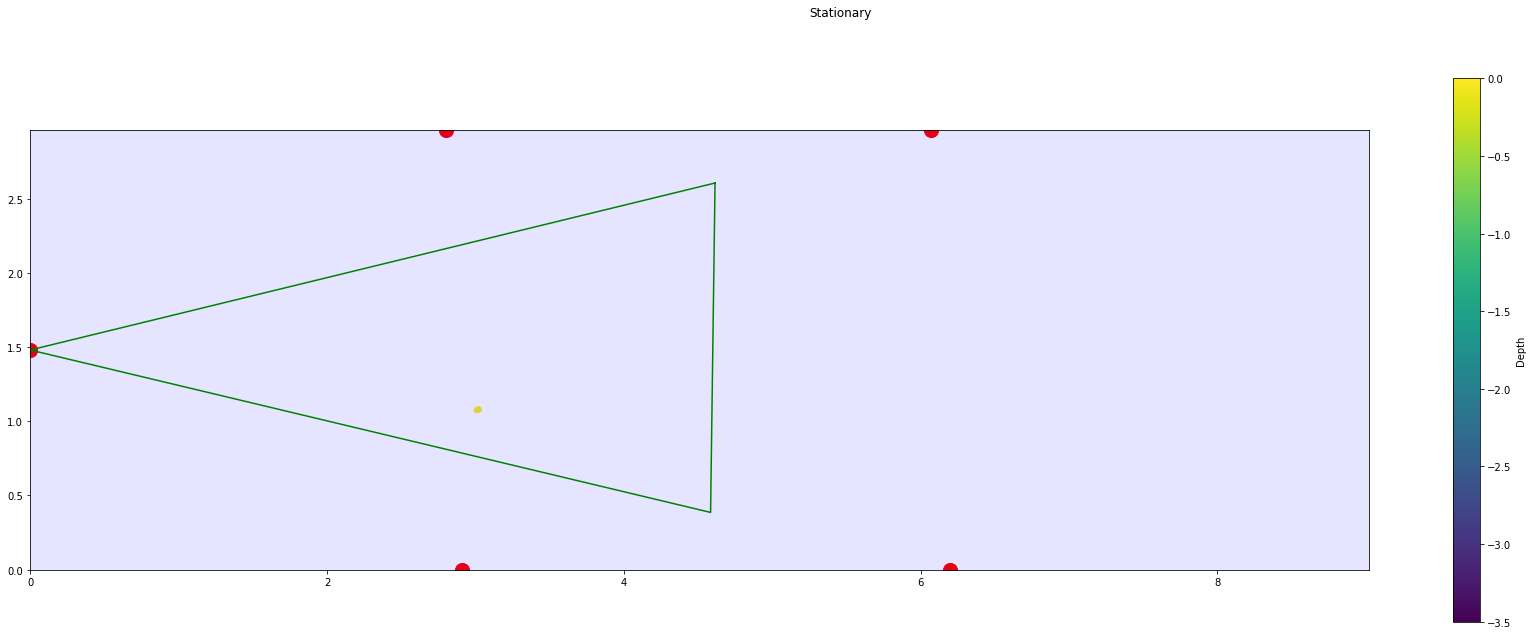

In [353]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax)
symbols = list("ov^<>sPD")
plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=20, vmin=D, vmax=0)
# plt.scatter(x0[:, 0], x0[:, 1], c=x0[:, 2], s=20, vmin=D, vmax=0)

plt.colorbar(label='Depth')

f.suptitle("Stationary")

# cs = [
#       ax.add_patch(mp_patches.Circle(loc[:2], 0, fill=False, alpha=0.2, linewidth=5))
#       for loc in h_locs
# ]

Text(0.5, 0.98, 'Stationary')

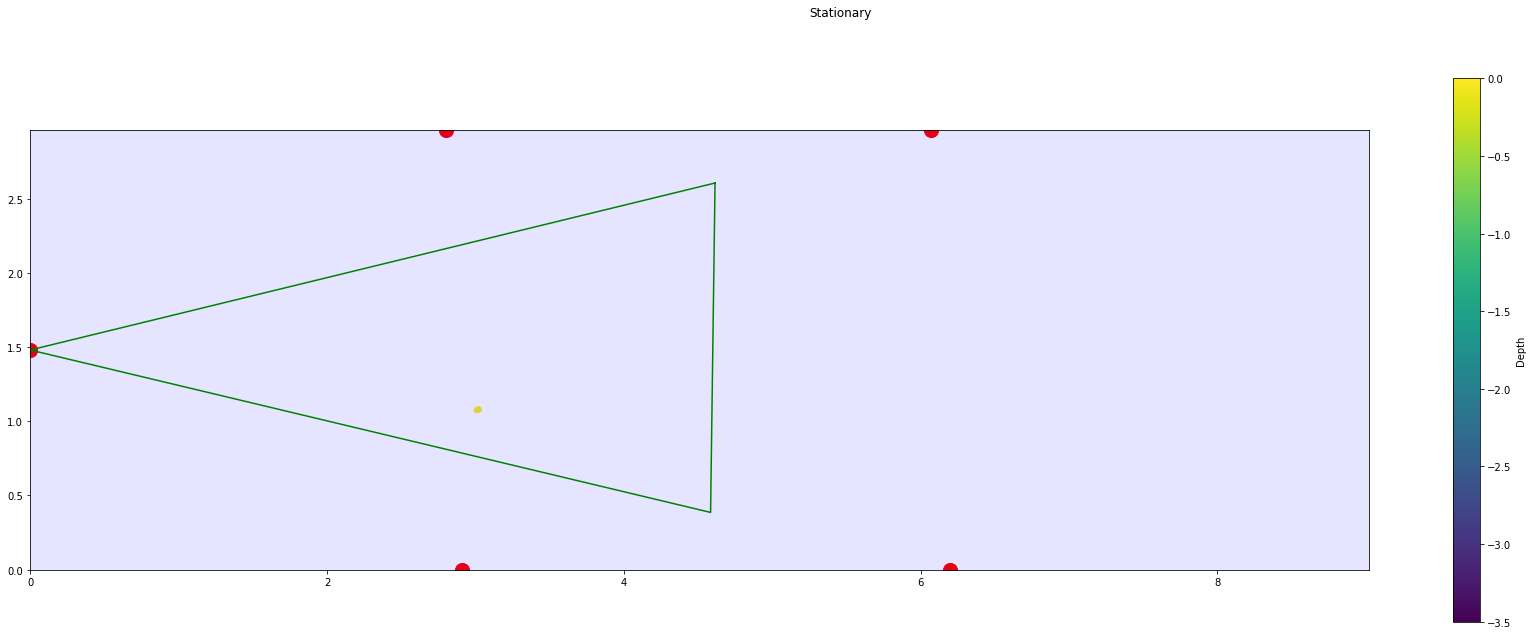

In [354]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax)
symbols = list("ov^<>sPD")
plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=20, vmin=D, vmax=0)
# plt.scatter(x0[:, 0], x0[:, 1], c=x0[:, 2], s=20, vmin=D, vmax=0)

plt.colorbar(label='Depth')

f.suptitle("Stationary")

# cs = [
#       ax.add_patch(mp_patches.Circle(loc[:2], 0, fill=False, alpha=0.2, linewidth=5))
#       for loc in h_locs
# ]

# Full

In [241]:
import numpy as np
from scipy.optimize import minimize
def get_ranges_from_file(run_number):
    run = runs[run_number]
    pico_file = f"{root}/{run}/pico.npts"
    _, y = load_pico_file(pico_file)
    
    indices = get_ping_indices(y[:, 0])
    ranges = np.vstack([get_ranges(y[:, 1:], index) for index in indices])
    valid_ranges = ~np.isnan(ranges).any(axis=1)
    indices, ranges = indices[valid_ranges], ranges[valid_ranges]

    return indices * dt, ranges

In [293]:
import numpy as np
from scipy.optimize import minimize
def get_simple_locs_from_file(run_number):
    run = runs[run_number]
    pico_file = f"{root}/{run}/pico.npts"
    _, y = load_pico_file(pico_file)
    
    indices = get_ping_indices(y[:, 0])
    ranges = 0.01578795189472405 + 0.7183563433803977 * np.vstack([get_ranges(y[:, 1:], index) for index in indices])
    valid_ranges = ~np.isnan(ranges).any(axis=1)
    indices, ranges = indices[valid_ranges], ranges[valid_ranges]

    def error(x, c, r):
        return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)
    
    l_h_locs = h_locs[[0,1,3,4], :]
    l_ranges = ranges[:, [0,1,3,4]]

    x0 = (l_h_locs[None, :, :] * 1.0 / l_ranges[:, :, None]).sum(axis=1) / (1.0 / l_ranges[:, :, None]).sum(axis=1)

    locs = np.empty((ranges.shape[0], h_locs.shape[1]))
    for i, (xx0, ran) in enumerate(zip(x0, l_ranges)):
        locs[i] = minimize(error, xx0, args=(l_h_locs[:, :], ran), method='Nelder-Mead').x
    
    return indices * dt, locs

In [42]:
import numpy as np
from scipy.optimize import minimize

def get_simple_locs_fix_depth(run_number, depth=-0.5):
    run = runs[run_number]
    pico_file = f"{root}/{run}/pico.npts"
    _, y = load_pico_file(pico_file)
    
    indices = get_ping_indices(y[:, 0])
    ranges = np.vstack([get_ranges(y[:, 1:], index) for index in indices])
    valid_ranges = ~np.isnan(ranges).any(axis=1)
    indices, ranges = indices[valid_ranges], ranges[valid_ranges]
    
    dists_2d = np.sqrt(ranges**2 - (h_locs[:, 2] - depth)**2)

    def error(x, c, r):
        return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

    x0 = (h_locs[None, :, :2] * 1.0 / ranges[:, :, None]).sum(axis=1) / (1.0 / ranges[:, :, None]).sum(axis=1)

    locs = np.empty((ranges.shape[0], h_locs.shape[1]))
    locs[:, 2] = depth
    for i, (xx0, ran) in enumerate(zip(x0, dists_2d)):
        locs[i, :2] = minimize(error, xx0, args=(h_locs[:, :2], ran), method='Nelder-Mead').x
    
    return indices * dt, locs

In [356]:
import numpy as np
from scipy.optimize import minimize
def get_simple_locs_with_remap(run_number, remap=[0,1,2,3,4]):
    run = runs[run_number]
    pico_file = f"{root}/{run}/pico.npts"
    _, y = load_pico_file(pico_file)
    
    indices = get_ping_indices(y[:, 0])
    ranges =  np.vstack([get_ranges(y[:, 1:], index) for index in indices])
    valid_ranges = ~np.isnan(ranges).any(axis=1)
    ranges = ranges[:, remap]
    indices, ranges = indices[valid_ranges], ranges[valid_ranges]

    def error(x, c, r):
        return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)
    
    l_h_locs = h_locs[[0,1,3,4], :]
    l_ranges = ranges[:, [0,1,3,4]]

    x0 = (l_h_locs[None, :, :] * 1.0 / l_ranges[:, :, None]).sum(axis=1) / (1.0 / l_ranges[:, :, None]).sum(axis=1)

    locs = np.empty((ranges.shape[0], h_locs.shape[1]))
    for i, (xx0, ran) in enumerate(zip(x0, l_ranges)):
        locs[i] = minimize(error, xx0, args=(l_h_locs[:, :], ran), method='Nelder-Mead').x
    
    return indices * dt, locs

In [43]:
ts, locs = get_simple_locs_fix_depth(2)

  0%|          | 0/515 [00:00<?, ?it/s]

/tmp/ipykernel_32150/1335940550.py:14: RuntimeWarning: invalid value encountered in sqrt
  dists_2d = np.sqrt(ranges**2 - (h_locs[:, 2] - depth)**2)


Text(0.5, 0.98, 'Stationary')

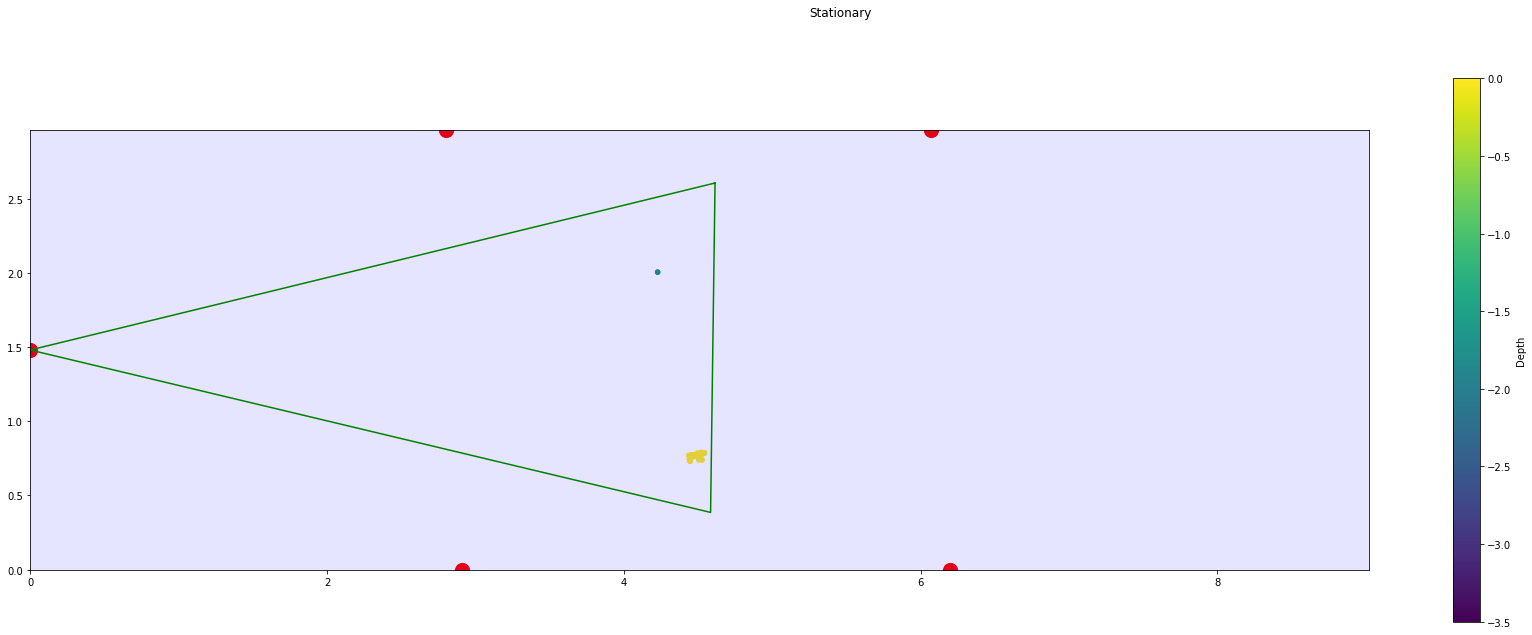

In [64]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax)
symbols = list("ov^<>sPD")
plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=20, vmin=D, vmax=0)
plt.scatter(all_locs[0][:, 0], all_locs[0][:, 1], c=all_locs[0][:, 2], s=20, vmin=D, vmax=0)

plt.colorbar(label='Depth')

f.suptitle("Stationary")


# Plots

In [59]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Channel')

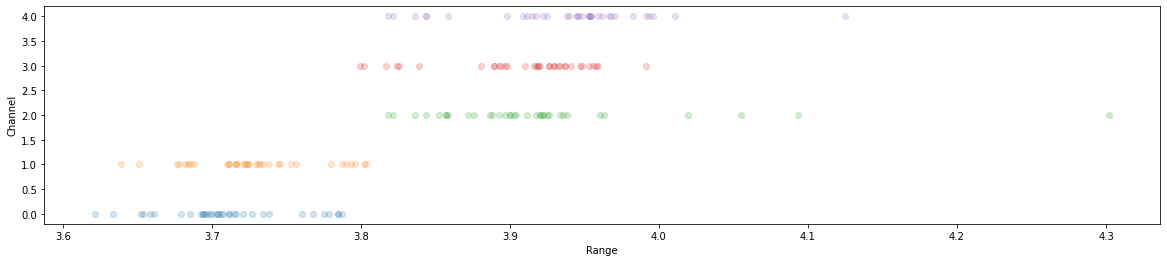

In [221]:
plt.figure(figsize=(20,4))
for i in range(ranges.shape[1]):
    plt.plot(ranges[:, i], np.zeros_like(ranges[:, i]) + i, 'o', alpha=0.2)
plt.xlabel('Range')
plt.ylabel('Channel')

In [294]:
# Get all locs:
all_ts = []
all_locs = []
for i in trange(2, 2 + 8):
    ts, locs = get_simple_locs_from_file(i)
    all_ts.append(ts)
    all_locs.append(locs)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/530 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Stationary')

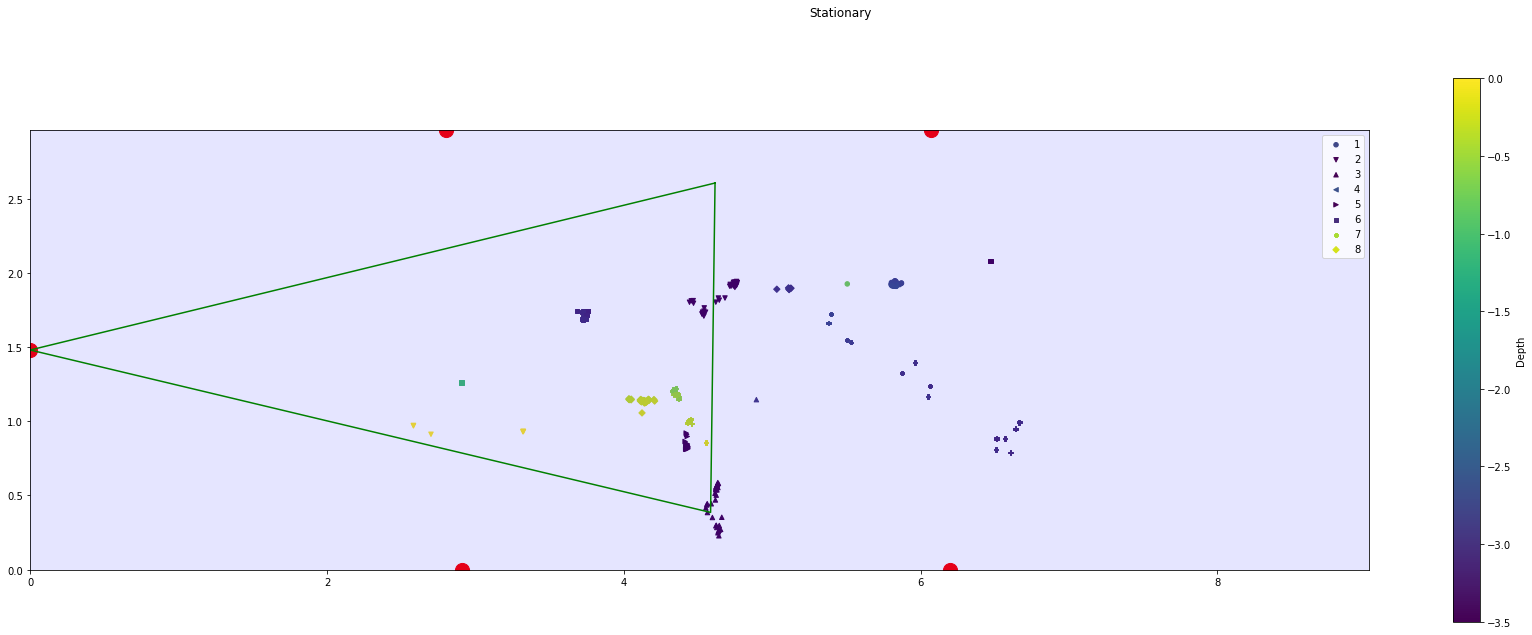

In [296]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax)
symbols = list("ov^<>sPD")
for i, (locs, sym) in enumerate(zip(all_locs, symbols), 1):
    plt.scatter(locs[:, 0], locs[:, 1], marker=sym, c=locs[:, 2], s=20, vmin=D, vmax=0, label=f"{i}")

plt.colorbar(label='Depth')

plt.legend()
f.suptitle("Stationary")


Text(0.5, 0.98, 'Stationary')

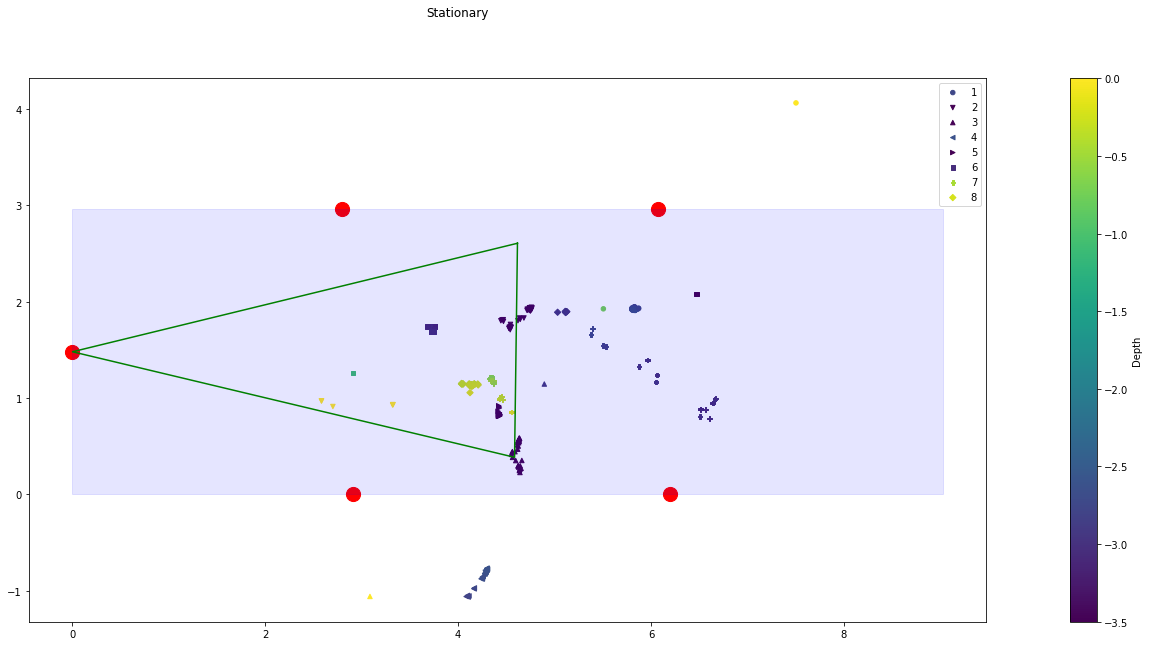

In [297]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax, set_lim=False)
symbols = list("ov^<>sPD")
for i, (locs, sym) in enumerate(zip(all_locs, symbols), 1):
    plt.scatter(locs[:, 0], locs[:, 1], marker=sym, c=locs[:, 2], s=20, vmin=D, vmax=0, label=f"{i}")

plt.colorbar(label='Depth')

plt.legend()
f.suptitle("Stationary")


# Try to get a linear fit

In [242]:
# Get all ranges:
all_ranges = []
for i in trange(2, 2 + 8):
    _, ran = get_ranges_from_file(i)
    all_ranges.append(ran)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/530 [00:00<?, ?it/s]

In [245]:
all_ranges_mean = np.vstack(tuple(np.nanmean(r, axis=0) for r in all_ranges))
all_ranges_mean

array([[3.11088211, 3.39531474, 4.83597789, 4.79812105, 4.82865579],
       [5.179112  , 4.70791289, 3.96893244, 3.94735733, 3.96955733],
       [6.52819778, 3.20510444, 3.18615222, 3.20535111, 4.28871111],
       [8.09196727, 2.10701545, 2.08939   , 2.10768818, 4.87717182],
       [6.50632667, 3.18956444, 3.16802222, 3.19009889, 3.54612111],
       [4.94706244, 4.8454478 , 2.77954829, 2.75359415, 2.80355317],
       [3.39040737, 3.35597789, 3.38701895, 3.79086421, 5.25158526],
       [3.71019086, 3.72858514, 3.92085829, 3.90732686, 3.93641943]])

In [246]:
actual_all_ranges = np.array((
    (1.51,3.23,4.77,3.72,2.30),
    (3.33,4.14,2.96,2.98,1.70),
    (4.79,5.22,1.54,3.12,2.33),
    (6.24,6.46,0.50,3.86,3.50),
    (4.99,5.02,1.55,2.78,2.73),
    (3.86,3.57,3.00,2.20,2.64),
    (2.97,1.96,4.74,2.68,3.48),
    (2.08,2.41,4.64,3.05,2.78)
))

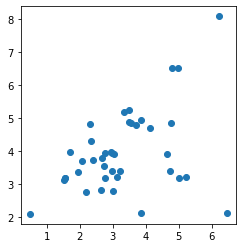

In [253]:
plt.gca().set_aspect('equal', 'box')
plt.scatter(actual_all_ranges, all_ranges_mean)

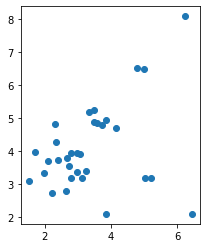

In [252]:
plt.scatter(actual_all_ranges[:, [0,1,3,4]], all_ranges_mean[:, [0,1,3,4]])
plt.gca().set_aspect('equal', 'box')

In [254]:
from numpy.polynomial import Polynomial as Poly

In [262]:
Poly.fit(all_ranges_mean[:, [0,1,3,4]].ravel(), actual_all_ranges[:, [0,1,3,4]].ravel(), 1, domain=[])#(0,10))

Polynomial([1.9754456, 0.3385314], domain=[-1.,  1.], window=[-1.,  1.])

In [263]:
Poly.fit?

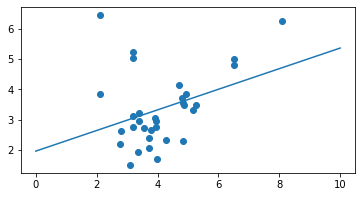

In [265]:
plt.scatter(all_ranges_mean[:, [0,1,3,4]], actual_all_ranges[:, [0,1,3,4]])
x = np.linspace(0,10,100)
y = 1.9754455977760899 + 0.33853139500853524 * x
plt.plot(x,y)
plt.gca().set_aspect('equal', 'box')

In [270]:
mask = ~((actual_all_ranges[:, [0,1,3,4]] / all_ranges_mean[:, [0,1,3,4]] ) > 1)

In [313]:
Poly.fit(all_ranges_mean[:, [0,2,3,4]][mask].ravel(), actual_all_ranges[:, [0,2,3,4]][mask].ravel(), 1, domain=[])#(0,10))

Polynomial([0.59158948, 0.63043016], domain=[-1.,  1.], window=[-1.,  1.])

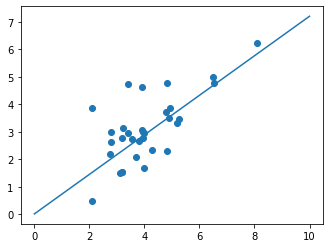

In [312]:
plt.scatter(all_ranges_mean[:, [0,2,3,4]], actual_all_ranges[:, [0,2,3,4]])
x = np.linspace(0,10,100)
y = 0.01578795189472405 + 0.7183563433803977 * x
plt.plot(x,y)
plt.gca().set_aspect('equal', 'box')

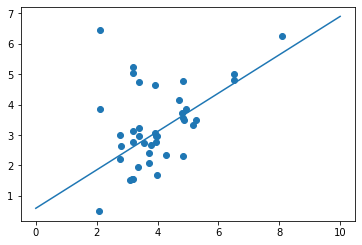

In [315]:
plt.scatter(all_ranges_mean[:, [0,1,2,3,4]], actual_all_ranges[:, [0,1,2,3,4]])
x = np.linspace(0,10,100)
y = 0.5915894806437689+0.6304301582955311*x
plt.plot(x,y)
plt.gca().set_aspect('equal', 'box')

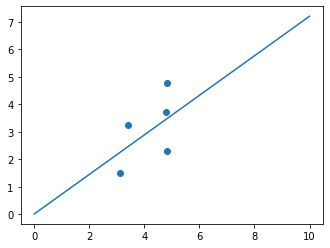

In [301]:
plt.scatter(all_ranges_mean[0, [0,1,2, 3,4]], actual_all_ranges[0, [0,1,2,3,4]])
x = np.linspace(0,10,100)
y = 0.01578795189472405 + 0.7183563433803977 * x
plt.plot(x,y)
plt.gca().set_aspect('equal', 'box')

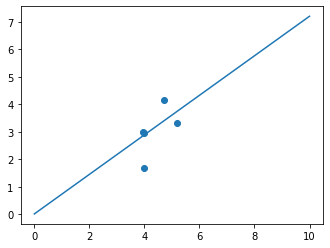

In [306]:
plt.scatter(all_ranges_mean[1, [0,1,2, 3,4]], actual_all_ranges[1, [0,1,2,3,4]])
x = np.linspace(0,10,100)
y = 0.01578795189472405 + 0.7183563433803977 * x
plt.plot(x,y)
plt.gca().set_aspect('equal', 'box')

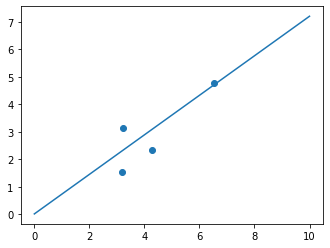

In [309]:
plt.scatter(all_ranges_mean[2, [0,2, 3,4]], actual_all_ranges[2, [0,2,3,4]])
x = np.linspace(0,10,100)
y = 0.01578795189472405 + 0.7183563433803977 * x
plt.plot(x,y)
plt.gca().set_aspect('equal', 'box')

# Randomly swap channels around

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/518 [00:03<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/530 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

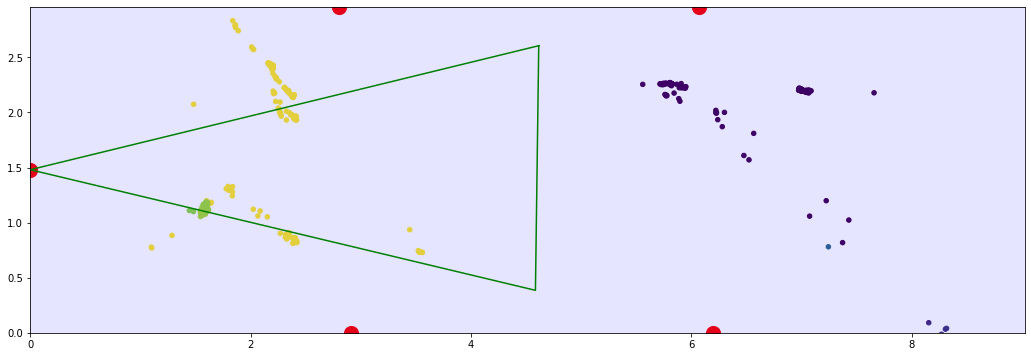

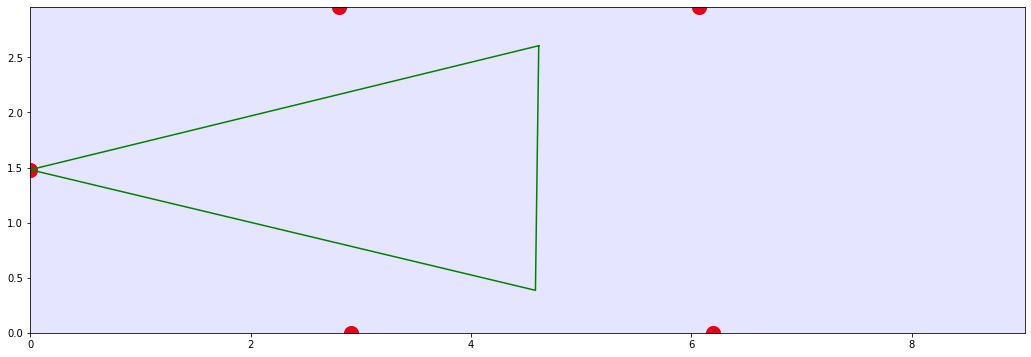

In [365]:
import itertools
for k,l in itertools.combinations(range(5),2):
    ind = list(range(5))
    ind[k] = l
    ind[l] = k
    plt.figure(figsize=(18,6))
    draw_pool(plt.gca())
    for i in trange(2, 2 + 8):
        _, locs = get_simple_locs_with_remap(i, ind)
        plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=20, vmin=D, vmax=0, label=f"{i-1}")